# Image Segmentation using U-Net architecture

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets pytorch_model_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.9 MB/s eta 0

In [2]:
# Import libraries
import os

import torch
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_model_summary import summary
from torch_snippets import *

from sklearn.model_selection import train_test_split

!nvidia-smi # check if GPU is available
%matplotlib inline

Wed Mar  6 07:03:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download dataset and extract it
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip

In [5]:
# Set up normalization transform for images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet
])

In [6]:
# Create Dataset class to fetch images and labels
class SegmentationData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[idx]}.png', 1)
        image = cv2.resize(image, (224, 224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[idx]}.png', 0)
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
        return image, mask

    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([transform(image.copy() / 255.)[None] for image in images]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device) # Used for Cross Entropy Loss
        return images, ce_masks

In [7]:
# Create train and validation datasets
train_ds = SegmentationData('train')
val_ds = SegmentationData('test')

# Create a function to retrieve the dataloaders
def load_data(batch_size = 4):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)
    return train_dl, val_dl

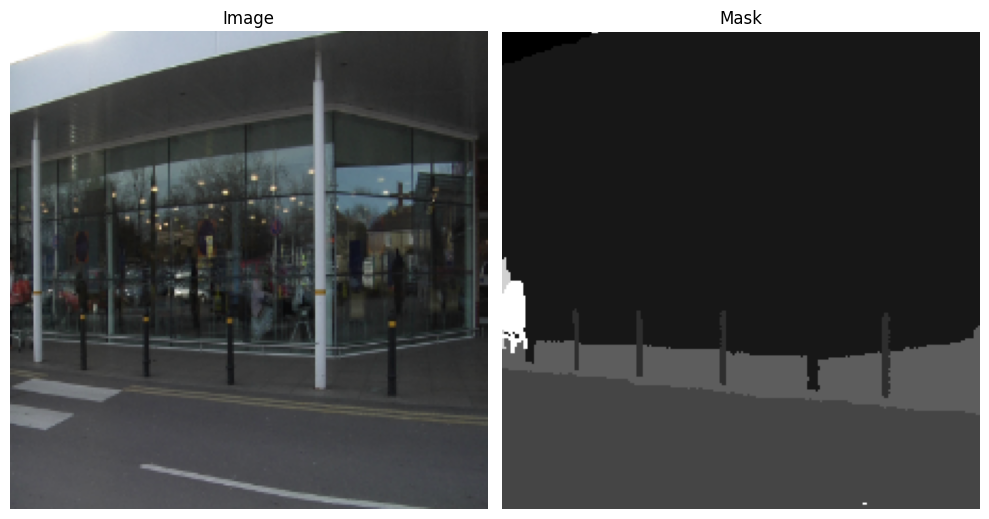

In [8]:
# Plot a sample image
image, mask = train_ds[44]
subplots([image, mask], nc=2, titles=['Image', 'Mask'], sz=10)

In [29]:
# Create a function for the convolutional block
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Create a function for the upsample block
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

# Create a class for the UNet model
class UNet(nn.Module):
    def __init__(self, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)
        return x

In [30]:
# Create a mock-up model and print summary
model = UNet().to(device)
print(summary(model, torch.zeros((1, 3, 224, 224)).to(device), show_input=True, show_hierarchical=True))

-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
=============================================================================
             Conv2d-1       [1, 3, 224, 224]           1,792           1,792
        BatchNorm2d-2      [1, 64, 224, 224]             128             128
               ReLU-3      [1, 64, 224, 224]               0               0
             Conv2d-4      [1, 64, 224, 224]          36,928          36,928
        BatchNorm2d-5      [1, 64, 224, 224]             128             128
               ReLU-6      [1, 64, 224, 224]               0               0
          MaxPool2d-7      [1, 64, 224, 224]               0               0
             Conv2d-8      [1, 64, 112, 112]          73,856          73,856
        BatchNorm2d-9     [1, 128, 112, 112]             256             256
              ReLU-10     [1, 128, 112, 112]               0               0
            Conv2d-11     [1, 128, 112, 112]         147,584         147,584
       BatchNorm2d-12     [1, 128, 112, 112]             256             256
              ReLU-13     [1, 128, 112, 112]               0               0
         MaxPool2d-14     [1, 128, 112, 112]               0               0
            Conv2d-15       [1, 128, 56, 56]         295,168         295,168
       BatchNorm2d-16       [1, 256, 56, 56]             512             512
              ReLU-17       [1, 256, 56, 56]               0               0
            Conv2d-18       [1, 256, 56, 56]         590,080         590,080
       BatchNorm2d-19       [1, 256, 56, 56]             512             512
              ReLU-20       [1, 256, 56, 56]               0               0
            Conv2d-21       [1, 256, 56, 56]         590,080         590,080
       BatchNorm2d-22       [1, 256, 56, 56]             512             512
              ReLU-23       [1, 256, 56, 56]               0               0
         MaxPool2d-24       [1, 256, 56, 56]               0               0
            Conv2d-25       [1, 256, 28, 28]       1,180,160       1,180,160
       BatchNorm2d-26       [1, 512, 28, 28]           1,024           1,024
              ReLU-27       [1, 512, 28, 28]               0               0
            Conv2d-28       [1, 512, 28, 28]       2,359,808       2,359,808
       BatchNorm2d-29       [1, 512, 28, 28]           1,024           1,024
              ReLU-30       [1, 512, 28, 28]               0               0
            Conv2d-31       [1, 512, 28, 28]       2,359,808       2,359,808
       BatchNorm2d-32       [1, 512, 28, 28]           1,024           1,024
              ReLU-33       [1, 512, 28, 28]               0               0
         MaxPool2d-34       [1, 512, 28, 28]               0               0
            Conv2d-35       [1, 512, 14, 14]       2,359,808       2,359,808
       BatchNorm2d-36       [1, 512, 14, 14]           1,024           1,024
              ReLU-37       [1, 512, 14, 14]               0               0
            Conv2d-38       [1, 512, 14, 14]       2,359,808       2,359,808
       BatchNorm2d-39       [1, 512, 14, 14]           1,024           1,024
              ReLU-40       [1, 512, 14, 14]               0               0
            Conv2d-41       [1, 512, 14, 14]       2,359,808       2,359,808
       BatchNorm2d-42       [1, 512, 14, 14]           1,024           1,024
              ReLU-43       [1, 512, 14, 14]               0               0
         MaxPool2d-44       [1, 512, 14, 14]               0               0
            Conv2d-45         [1, 512, 7, 7]       4,719,616       4,719,616
       BatchNorm2d-46        [1, 1024, 7, 7]           2,048           2,048
              ReLU-47        [1, 1024, 7, 7]               0               0
   ConvTranspose2d-48        [1, 1024, 7, 7]       2,097,664       2,097,664
              ReLU-49       [1, 512, 14, 14]               0           

In [31]:
# Create a loss function for the UNet model
ce = nn.CrossEntropyLoss()

def unet_loss(preds, targets):
    ce_loss = ce(preds, targets)
    accuracy = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, accuracy

In [32]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, ce_masks = data
    pred_masks = model(images)
    loss, accuracy = criterion(pred_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, masks = data
    pred_masks = model(images)
    loss, accuracy = criterion(pred_masks, masks)
    return loss.item(), accuracy.item()

EPOCH: 1.000  val_loss: 0.839  train_loss: 1.116  train_acc: 0.755  val_acc: 0.788  (22.03s - 418.61s remaining)
EPOCH: 2.000  val_loss: 0.703  train_loss: 0.644  train_acc: 0.831  val_acc: 0.811  (39.47s - 355.25s remaining)
EPOCH: 3.000  val_loss: 0.646  train_loss: 0.549  train_acc: 0.847  val_acc: 0.833  (57.05s - 323.29s remaining)
EPOCH: 4.000  val_loss: 0.476  train_loss: 0.478  train_acc: 0.864  val_acc: 0.870  (74.89s - 299.58s remaining)
EPOCH: 5.000  val_loss: 0.475  train_loss: 0.412  train_acc: 0.880  val_acc: 0.867  (92.65s - 277.94s remaining)
EPOCH: 6.000  val_loss: 0.467  train_loss: 0.378  train_acc: 0.888  val_acc: 0.857  (110.92s - 258.80s remaining)
EPOCH: 7.000  val_loss: 0.412  train_loss: 0.340  train_acc: 0.897  val_acc: 0.865  (129.42s - 240.35s remaining)
EPOCH: 8.000  val_loss: 0.396  train_loss: 0.322  train_acc: 0.901  val_acc: 0.875  (147.55s - 221.33s remaining)
EPOCH: 9.000  val_loss: 0.445  train_loss: 0.303  train_acc: 0.905  val_acc: 0.863  (165.51s 

100%|██████████| 121/121 [00:00<00:00, 1323.72it/s]


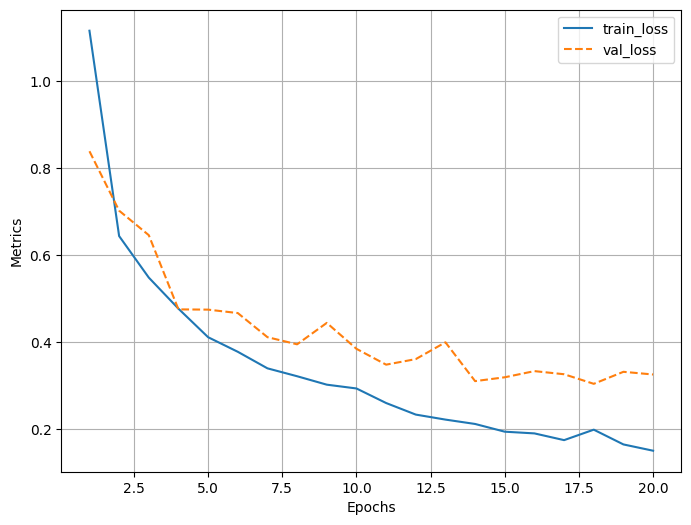

In [33]:
# Train the model
model = UNet().to(device)
criterion = unet_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 20
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, train_acc=acc, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['train_loss', 'val_loss'])

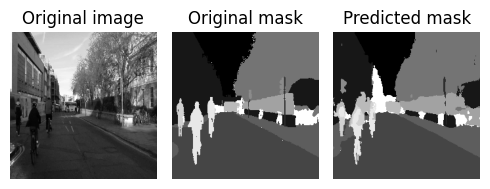

In [34]:
# Make a prediction on a sample image
image, mask = next(iter(val_dl))
pred_mask = model(image)
_, pred_mask = torch.max(pred_mask, dim=1)
subplots(
    [
        image[0].permute(1,2,0).detach().cpu()[:,:,0], # Original image
        mask.permute(1,2,0).detach().cpu()[:,:,0], # Original mask
        pred_mask.permute(1,2,0).detach().cpu()[:,:,0] # Predicted mask
    ],
    nc=3, titles=['Original image', 'Original mask', 'Predicted mask'], sz=5
)